In [ ]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

In [ ]:
# Make a list of calibration images
fname = 'camera_cal/calibration1.jpg'
img = cv2.imread(fname)
plt.imshow(img)
plt.show()

In [ ]:
def getCalPoints(pathToImages, kernel=(9, 6)):

    objpoints = []
    imgpoints = []
    
    nx = kernel[0]
    ny = kernel[1]

    objp       = np.zeros((nx * ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    images = glob.glob(pathToImages + '*.jpg')

    for idx, fname in enumerate(images):
        image = cv2.imread(fname)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            img = cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.title(fname)
            plt.imshow(img);
            plt.axis('off')
            plt.show()
    
    return objpoints, imgpoints, gray.shape

In [ ]:
objpoints, imgpoints, grayshape = getCalPoints('camera_cal/calibration', (9, 6));

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera( objpoints, 
                                                    imgpoints, 
                                                    grayshape[::-1], 
                                                    None, 
                                                    None)

In [ ]:
def plotUndistorted(pathToImages, mtx, dist):
    
    images = glob.glob(pathToImages + '*.jpg')
    nimgs = len(images)
    fig = plt.figure(figsize=(8, 2 * nimgs))

    for idx, fname in enumerate(images):
        image = cv2.imread(fname)
        undist = cv2.undistort(image, mtx, dist, None, mtx)
        undist = cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(nimgs, 2, 2 * idx + 1)
        plt.imshow(image)
        plt.axis('off')
        fig.add_subplot(nimgs, 2, 2 * idx + 2)
        plt.imshow(undist)
        plt.axis('off')
    
    plt.show()

In [ ]:
plotUndistorted('camera_cal/calibration', mtx, dist)

In [ ]:
def getGridAreas(pathToImages, kernel=(9, 6)):
    
    nx = kernel[0]
    ny = kernel[1]

    images = glob.glob(pathToImages + '*.jpg')

    for idx, fname in enumerate(images):
        image = cv2.imread(fname)
        undist = cv2.undistort(image, mtx, dist, None, mtx)
        gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        if ret == True:
            # Draw and display the corners
            cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
            offset = 100
            img_size = (gray.shape[1], gray.shape[0])
            src = np.float32([corners[0], 
                              corners[nx-1], 
                              corners[-1], 
                              corners[-nx]])
            dst = np.float32([[offset, offset], 
                              [img_size[0]-offset, offset], 
                              [img_size[0]-offset, img_size[1]-offset], 
                              [offset, img_size[1]-offset]])
            M = cv2.getPerspectiveTransform(src, dst)
            warped = cv2.warpPerspective(undist, M, img_size)
            plt.title(fname)
            plt.imshow(warped);
            plt.axis('off')
            plt.show()

In [ ]:
getGridAreas('camera_cal/calibration')

In [1953]:
def colorSpaceRed(image):
    return image[:,:,2]

def colorSpaceS(image):
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    S   = hls[:,:,2]
    return S

def colorSpaceH(image):
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    H   = hls[:,:,0]
    return H

def colorSpaceY(image):
    yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    Y   = yuv[:,:,0]
    return Y

def colorSpaceU(image):
    yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    U   = yuv[:,:,1]
    return U

def colorSpaceGray(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def colorSpaceB(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    l,a,b = cv2.split(lab)
    return b

def colorSpace(image, color):
    if color == 'red':
        image = colorSpaceR(image)
    if color == 's':
        image = colorSpaceS(image)
    if color == 'y':
        image = colorSpaceY(image)
    if color == 'gray':
        image = colorSpaceG(image)
    if color == 'b':
        image = colorSpaceB(image)
    if color == 'u':
        image = colorSpaceU(image)
    if color == 'h':
        image = colorSpaceH(image)
    return image

In [1963]:
def testFunc(image, evalfunc, colorspace):
    image   = cv2.imread(image)
    fig     = plt.figure(figsize=(24, 8))
    
    gray = colorSpace(image, colorspace)
    testimg = evalfunc(gray)
    
    fig.add_subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    fig.add_subplot(1, 3, 2)
    plt.imshow(gray,)
    plt.axis('off')
    fig.add_subplot(1, 3, 3)
    plt.imshow(testimg, cmap='gray')
    plt.axis('off')
    
    plt.show()

In [1964]:
def sobel_detect(img, sobel_kernel=3, thresh=(10, 255), dir_thresh=(0, np.pi/2), mag_thresh=(0, 255)):
    
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    scaled_sobel = np.uint8( 255 * ( np.abs(sobelx) + np.abs(sobely) ) / np.max( np.abs(sobelx) + np.abs(sobely) ) )
    
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    
    binary_output[ ( ( (absgraddir >= dir_thresh[0] - np.pi/7) & (absgraddir <= dir_thresh[0] + np.pi/7) ) |
                     ( (absgraddir >= dir_thresh[1] - np.pi/7) & (absgraddir <= dir_thresh[1] + np.pi/7) ) ) & 
                     ( (gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1]) ) & 
                     ( (scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1]) ) ] = 1
    
    return binary_output

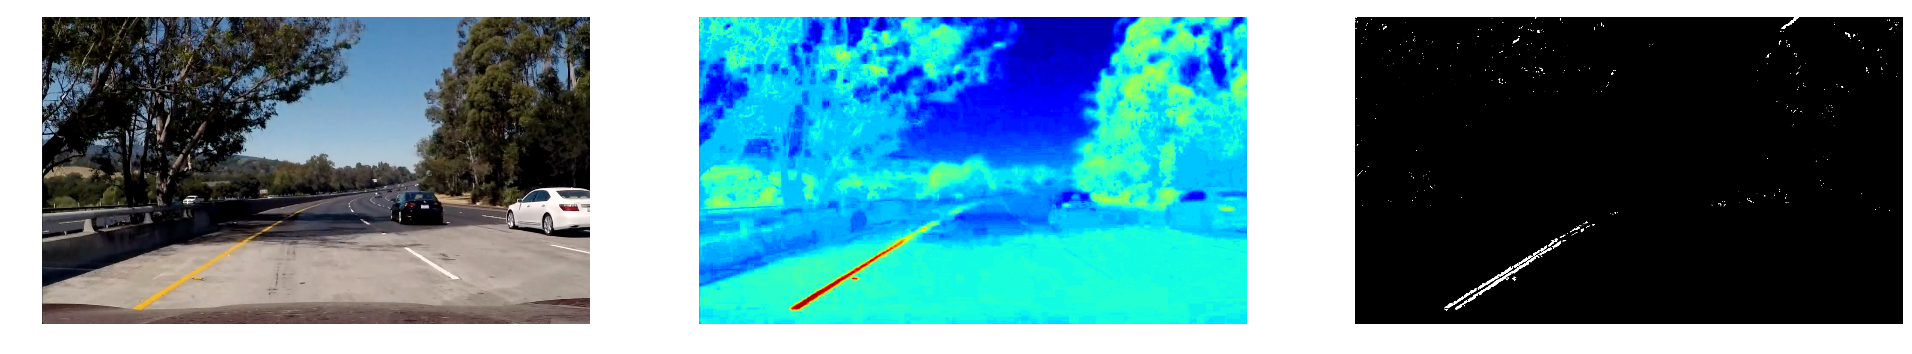

In [2055]:
def sobel_test(image):
    return sobel_detect(image, sobel_kernel=5, thresh=(40,255), dir_thresh=(0.78,2.35), mag_thresh=(50,255))

testFunc('test_images/test5.jpg', sobel_test, colorspace='b')

In [1966]:
def range_select(img, thresh=(0, 255)):
    
    binary_output = np.zeros_like(img)
    
    binary_output[(img >= thresh[0]) & (img <= thresh[1])] = 1
    
    return binary_output

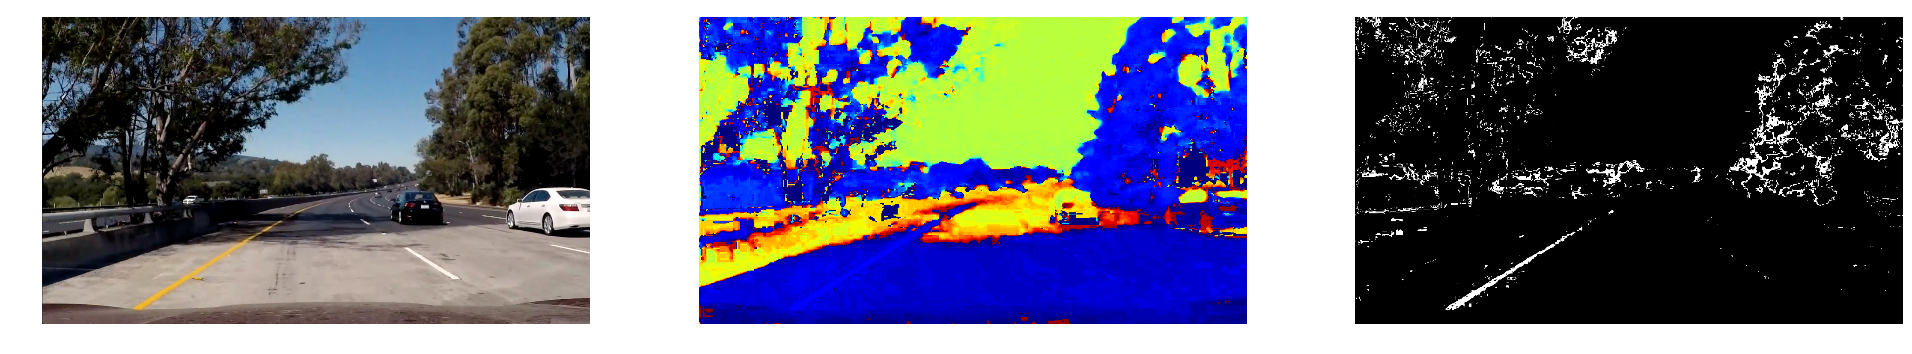

In [2056]:
def range_test(image):
    return range_select(image, thresh=(20, 22))

testFunc('test_images/test5.jpg', range_test, colorspace='h')

In [2057]:
def pipeline(img):
    
    # undistort image
    image = cv2.undistort(img, mtx, dist, None, mtx)
    
    sobelr = sobel_detect(colorSpace(image, 'red'), sobel_kernel=5, thresh=(40,255), dir_thresh=(0.78,2.35), mag_thresh=(50,255))
    sobels = sobel_detect(colorSpace(image, 's'), sobel_kernel=5, thresh=(100,255), dir_thresh=(0.78,2.35), mag_thresh=(120,255))
    sobelb = sobel_detect(colorSpace(image, 'b'), sobel_kernel=5, thresh=(50,255), dir_thresh=(0.78,2.35), mag_thresh=(60,255))
    
    rangeds = range_select(colorSpace(image, 's'), thresh=(210, 254))
    rangedb = range_select(colorSpace(image, 'b'), thresh=(155, 254))
    rangedh = range_select(colorSpace(image, 'h'), thresh=(30, 50))
    rangedr = range_select(colorSpace(image, 'red'), thresh=(225, 255))
    
    """
    plt.figure(figsize=(16,16))
    plt.imshow(sobelr, cmap='gray')
    plt.show()
    plt.figure(figsize=(16,16))
    plt.imshow(sobels, cmap='gray')
    plt.show()
    plt.figure(figsize=(16,16))
    plt.imshow(sobelb, cmap='gray')
    plt.show()
    plt.figure(figsize=(16,16))
    plt.imshow(rangeds, cmap='gray')
    plt.show()
    plt.figure(figsize=(16,16))
    plt.imshow(rangedb, cmap='gray')
    plt.show()
    plt.figure(figsize=(16,16))
    plt.imshow(rangedh, cmap='gray')
    plt.show()
    plt.figure(figsize=(16,16))
    plt.imshow(rangedr, cmap='gray')
    plt.show()
    """
        
    combined = np.zeros_like(dir_binary)
    combined[(sobelr == 1) | (sobels == 1) | (sobelb == 1) | (rangeds == 1) | (rangedb == 1) | (rangedr == 1) | (rangedh == 1)] = 1
    
    return combined

In [2058]:
def transform(image, erode=1):
    
    img_size = (image.shape[1], image.shape[0])
    offset = 300
    
    tolerance = 0.04
    
    src = np.float32([[img_size[0] * ( 0.5 - tolerance ), img_size[1] * 0.625], 
                      [img_size[0] * ( 0.5 + tolerance ), img_size[1] * 0.625], 
                      [img_size[0] * 0.9,  img_size[1]], 
                      [img_size[0] * 0.1,  img_size[1]]])
    
    dst = np.float32([[offset, 0], 
                      [img_size[0] - offset, 0], 
                      [img_size[0] - offset, img_size[1]], 
                      [offset, img_size[1]]])
    
    M = cv2.getPerspectiveTransform(src, dst)
                       
    warped = cv2.warpPerspective(image, M, img_size)
    
    if erode:
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
        erosion = cv2.erode(warped,kernel,iterations = 1)
        # normalize x and y dims, in this case, it is best just use inter_area
        # these values are empirical, but kinda similar to the ones by Udacity
        reduced = cv2.resize(erosion, (0,0), fx=1/4, fy=8/4, interpolation=cv2.INTER_AREA )  
    else:
        reduced = cv2.resize(warped, (0,0), fx=1/4, fy=8/4, interpolation=cv2.INTER_AREA )  
    
    saturated = np.zeros_like(reduced)
    saturated[reduced > 0] = 1
    
    gray = np.uint8( 255 * saturated )
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(gray,cv2.MORPH_OPEN,kernel, iterations = 1)
                           
    return opening

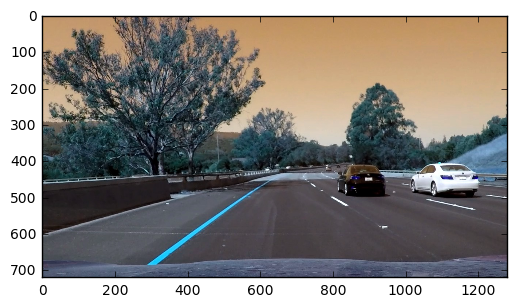

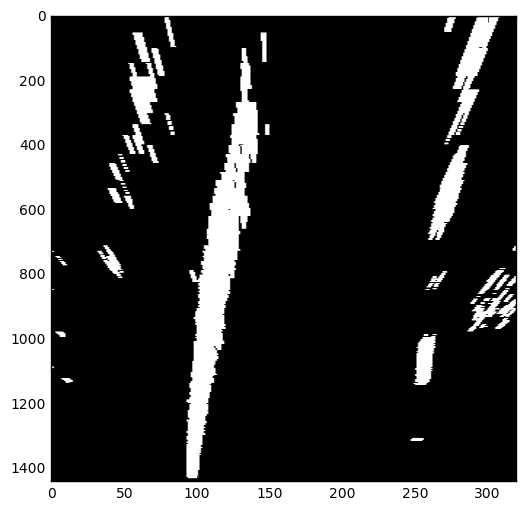

In [2064]:
image = cv2.imread('test_images/test6.jpg')
plt.imshow(image)
plt.show()
procimg = pipeline(image)
warped = transform(procimg, 0)
plt.figure(figsize=(6,6))
plt.imshow(warped, cmap='gray', aspect='auto')
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

# Obtain clusters of pixels in image section and return them
# along with how many points were classified into clusters

def clusterizeSection(section, radius=20):
    idxy, idxx = np.nonzero(section)
    
    #sectionlx = section.shape[1]
    #sectionly = section.shape[0]
    
    conv = [ [idxx[j], idxy[j]] for j in range(len(idxy)) ]
    
    if (len(conv)) > 0:
    
        X = np.array(conv) #StandardScaler().fit_transform(conv)
        db = DBSCAN(eps=radius, min_samples=10).fit(X)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        unique_labels = set(labels)

        means = []
        for k in unique_labels:
            class_member_mask = (labels == k)
            xy = X[class_member_mask & core_samples_mask]
            means.append([xy.mean(axis=0), len(xy)])
        
        return means
    else:
        return None

In [ ]:
def getPointBlobs(warped, slices=10, radius=20, scalef=1):
    all_means = []
    all_weights = []
        
    for i in range(slices * 2 - 1):

        step = warped.shape[0]//slices
        half_step = step//2
        end = warped.shape[0] - i * half_step
        start = end - step

        section = warped[start:end,:]
        histogram = np.sum(section[:,:], axis=0)
        
        means = clusterizeSection(section, radius)
        this_means = []
        this_weights = []

        if means is not None:
            for element in means:
                if element is not None:
                    if element[1] is not 0:
                        this_means.append([scalef * element[0][0], scalef * ( warped.shape[0] - ( start  + element[0][1] ))])
                        this_weights.append(element[1])
                
        if len(this_weights) > 0:
            all_means.append(this_means)
            all_weights.append(this_weights)

    return all_means, all_weights

In [ ]:
def clusterizeLanes(means, weights, pxtolerance=40, scalef=1):
    # clusterize upwards
    labels = []
    topmost = []
    labels_w = []
    # point labels should have len of points
    points_labels = []
    points = []
    
    count = 0
    
    if means is not None:
        for elements in means:
            if elements is not None:
                for mean in elements:
                    if mean is not None:
                        # look for correspondance, if not, add as new label
                        meanx = mean[0]
                        meany = mean[1]
                        label = -1
                        # look for min distance in X to topmost point
                        if len(topmost) > 0:
                            tops = np.array(topmost)
                            tops = tops[:,0]
                            tops = tops - meanx
                            tops = np.abs(tops)
                            idx  = np.argmin(tops)
                            # if a match if found, assign label to point
                            if abs(tops[idx]) <= pxtolerance * scalef:
                                label = idx
                                # if point is higher in Y update topmost
                                if meany > topmost[idx][1]:
                                    topmost[idx][0] = meanx
                                    topmost[idx][1] = meany
                        # if no match is found assume new label
                        if label == -1:
                            label = len(labels)
                            labels.append(label)
                            labels_w.append(0)
                            topmost.append(mean)
                        # assign label to point
                        points_labels.append(label)
                        points.append(mean)
                        labels_w[label] = labels_w[label] + 1
                        count = count + 1
    
    labels = np.array(labels)
    points_labels = np.array(points_labels)
    points = np.array(points)
    labels_w = np.array(labels_w)
    
    return labels, points_labels, points, labels_w

In [ ]:
def getLaneMeans(warped, order=5, closetol=20, longtol=30, graph=0, scalef=0.025):
    m,w = getPointBlobs(warped, order, closetol, scalef)
    l,pl,ps,lw = clusterizeLanes(m,w, longtol, scalef)

    if graph:
        unique_labels = set(l)
        colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
        for k, col in zip(unique_labels, colors):
            if k == -1:
                # Black used for noise.
                col = 'k'

            class_member_mask = (pl == k)

            xy = ps[class_member_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                     markeredgecolor='k', markersize=14)
        plt.show()
        
    return l, pl, ps, lw

In [ ]:
def getFits(l, pl, ps, lw, graph=0):
    colors = plt.cm.Spectral(np.linspace(0, 1, len(l)))
    # Apply fit to found points (more than 5!)
    fits = []
    curvs = []
    labels = []
    for k in l:
        if lw[k] > 8:
            points = ps[pl == k]
            xvals = points[:,0]
            yvals = points[:,1]
            p_fit = np.polyfit(yvals, xvals, 2)
            y_eval = np.min(yvals)
            p_curverad = ((1 + (2*p_fit[0]*y_eval + p_fit[1])**2)**1.5)/np.absolute(2*p_fit[0])
            fits.append(p_fit)
            curvs.append(p_curverad)
            labels.append(k)
            if graph:
                p_fitx = p_fit[0]*yvals**2 + p_fit[1]*yvals + p_fit[2]
                plt.plot(p_fitx, yvals, 'o', color=colors[k], linewidth=3)
    if graph:
        plt.show()
        
    return labels, fits, curvs

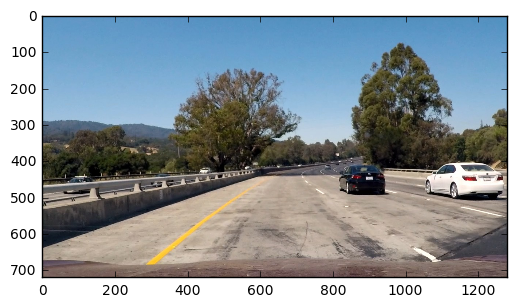

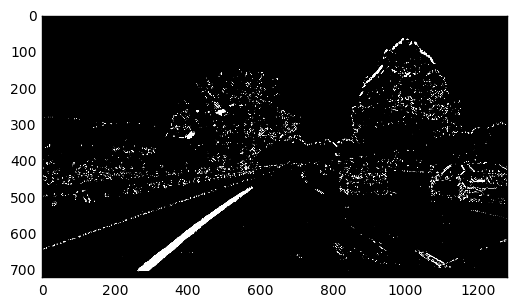

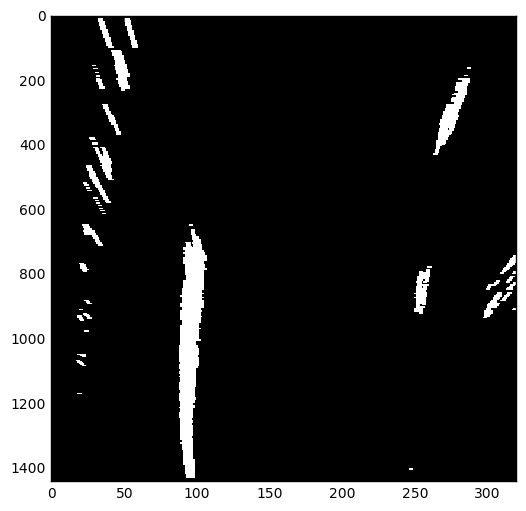

In [1923]:
# Use the found labels to obtain preliminary fits
image = cv2.imread('test_images/test1.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

procimg = pipeline(image)
plt.imshow(procimg, cmap='gray')
plt.show()

warped = transform(procimg)

plt.figure(figsize=(6,6))
plt.imshow(warped, cmap='gray', interpolation='none', aspect='auto')
plt.show()

C:\Users\uidp7273\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\Users\uidp7273\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\core\_methods.py:68: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\uidp7273\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\lines.py:1145: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


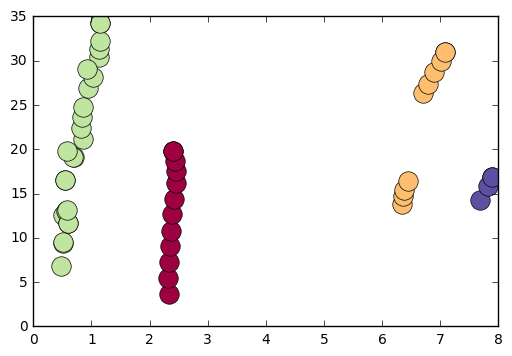

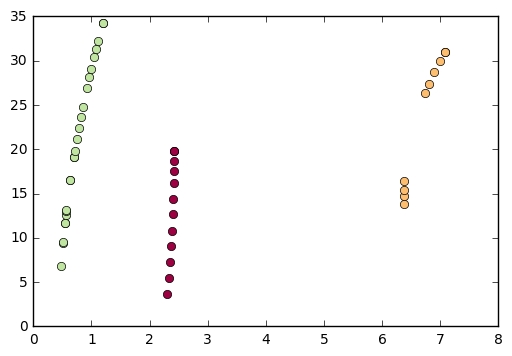

In [1929]:
image = cv2.imread('test_images/test1.jpg')
procimg = pipeline(image)
warped = transform(procimg)
l,pl,ps,lw = getLaneMeans(warped, 10, 20, 40, 1, 0.025)
lf,f,c = getFits(l, pl, ps, lw, 1)

In [1930]:
# Use found lane lines in an EM approach to improve fits, though ONLY for 
# left and right lanes, so find them, luckily, we already know 0!

# I WILL NOT handle lane changes, as I also believe this fundamentally
# requires a more sophisticated world model. I have done stuff extactly
# for this before but will not for this project

# extract fits at 0 value in x:
# zerox = half * scalef * image_x * image_resize_Factor
zerox = 0.5 * 0.025 * image.shape[1] / 4
fit0x = []
for k in range(len(lf)):
    label = lf[k]
    fit = f[k]
    fit0x.append(fit[2])
    
# find closest fits to car
fit0xnp = np.array(fit0x)
caroffset = fit0xnp - zerox
caroffset = np.abs(caroffset)
minidx = caroffset.argsort()[:]

# classify fits as feasible or not
left_fits = []
right_fits = []
for k in range(len(lf)):
    idx = minidx[k]
    if caroffset[idx] < 3.7:
        if f[idx][2] > zerox:
            right_fits.append(f[idx])
        if f[idx][2] < zerox:
            left_fits.append(f[idx])

# There might be many fits, use the best
right_fit = right_fits[0]
left_fit = left_fits[0]

print(right_fit)
print(left_fit)

[  2.66353535e-03  -7.84041468e-02   6.95253854e+00]
[ -4.40073502e-04   1.79223252e-02   2.24422329e+00]


In [ ]:
# Use an EM-like algo

image = cv2.imread('test_images/test1.jpg')
procimg = pipeline(image)
warped = transform(procimg, 0)

# Get ALL points of image
idxy, idxx = np.nonzero(warped)
fit = left_fit
scalef = 0.025
x_tol = 0.5

# See if they are within fit and use for optim
xvals = scalef * idxx[:]
yvals = scalef * ( warped.shape[0] - idxy[:] )

plt.plot(xvals, yvals, '.')
plt.show()
    
# 3 iterations seems enought though
for i in range(3):
    # Get points within range of fit
    # p_fitx = p_fit[0]*yvals**2 + p_fit[1]*yvals + p_fit[2]
    xfit = [ xvals[j] for j in range(len(xvals)) if (abs(fit[0]*yvals[j]**2 + fit[1]*yvals[j] + fit[2] - xvals[j]) < x_tol) ]
    yfit = [ yvals[j] for j in range(len(xvals)) if (abs(fit[0]*yvals[j]**2 + fit[1]*yvals[j] + fit[2] - xvals[j]) < x_tol) ]
    xvals = np.array(xfit)
    yvals = np.array(yfit)
    fit = np.polyfit(yvals, xvals, 2)

print(fit)

In [ ]:
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])

pts = np.hstack((pts_left, pts_right))
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

In [ ]:
import numpy as np
yvals = np.linspace(0, 100, num=101)*7.2

leftx = np.array([200 + (elem**2)*4e-4 + np.random.randint(-50, high=51) 
                              for idx, elem in enumerate(yvals)])
leftx = leftx[::-1]

rightx = np.array([900 + (elem**2)*4e-4 + np.random.randint(-50, high=51) 
                                for idx, elem in enumerate(yvals)])
rightx = rightx[::-1]

# Fit a second order polynomial to each fake lane line
left_fit = np.polyfit(yvals, leftx, 2)
left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]
right_fit = np.polyfit(yvals, rightx, 2)
right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]

# Plot up the fake data
plt.plot(leftx, yvals, 'o', color='red')
plt.plot(rightx, yvals, 'o', color='blue')
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, yvals, color='green', linewidth=3)
plt.plot(right_fitx, yvals, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images
plt.show()

In [ ]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(yvals)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) \
                             /np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) \
                                /np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1163.9    1213.7

In [ ]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meteres per pixel in x dimension

left_fit_cr = np.polyfit(yvals*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(yvals*ym_per_pix, rightx*xm_per_pix, 2)
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) \
                             /np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) \
                                /np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 3380.7 m    3189.3 m